<a href="https://colab.research.google.com/github/caseym7875/River-Flow-Prediction/blob/main/River_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dataretrieval

In [2]:
import dataretrieval.nwis as nwis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
from datetime import datetime, timezone, timedelta

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from time import time
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
import tensorflow as tf

import requests

# Data Loading

In [6]:
start_date = '1994-02-26'
end_date = '2024-06-17'

In [7]:
turq = pd.read_csv('https://dwr.state.co.us/Tools/Stations/ExportObsTsFileResult?abbrevs=LFCBSLCO&parameters=DISCHRG&por_start=' + start_date + 'T07%3A00%3A00.000Z&toDate=' + end_date + 'T05%3A59%3A59.000Z&timeStep=' + start_date + 'T07%3A00%3A00.000Z&por_end=' + end_date + 'T05%3A59%3A59.000Z&time_step=DailyAverage&obs_type=best&avg_time=12%3A00%20AM&is_x_tab=true')

In [9]:
twin = pd.read_csv('https://dwr.state.co.us/Tools/Stations/ExportObsTsFileResult?abbrevs=LAKBTLCO&parameters=DISCHRG&por_start=' + start_date + 'T06%3A00%3A00.000Z&toDate=' + end_date + 'T05%3A59%3A59.000Z&timeStep=' + start_date + 'T06%3A00%3A00.000Z&por_end=' + end_date + 'T05%3A59%3A59.000Z&time_step=HourlyAverage&obs_type=best&avg_time=12%3A00%20AM&is_x_tab=true')

EmptyDataError: No columns to parse from file

In [ ]:
twin = pd.read_csv('https://dwr.state.co.us/Tools/Stations/ExportObsTsFileResult?abbrevs=LAKBTLCO&parameters=DISCHRG&por_start=' + start_date + 'T06%3A00%3A00.000Z&toDate=' + end_date + 'T05%3A59%3A59.000Z&timeStep=' + start_date + 'T06%3A00%3A00.000Z&por_end=' + end_date + 'T05%3A59%3A59.000Z&time_step=HourlyAverage&obs_type=best&avg_time=12%3A00%20AM&is_x_tab=true')

EmptyDataError: No columns to parse from file

In [ ]:
def format_data(data):
  data = data.iloc[:, :data.columns.get_loc('2024') + 1]
  data['2024'].fillna(0, inplace=True)

  data['date'].fillna('02-29', inplace=True)

  # Create a new '1991' column and insert it as the second column
  data.insert(1, '1991', None)

  data.set_index('date', inplace=True)

  # Shift October - December data to the left
  mask = (data.index >= '10-01') & (data.index <= '12-31')
  data.iloc[mask, :-1] = data.iloc[mask, 1:].values

  # Sort and reset dates
  data.sort_index(inplace=True)
  data.reset_index(inplace=True)

  # Melt data into 1 column
  data = pd.melt(data, id_vars=['date'], var_name='year', value_name='value')
  data['datetime'] = data['date'] + '-' + data['year']
  data = data.drop(['date', 'year'], axis=1)
  data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
  data = data.dropna()
  data.set_index('datetime', inplace=True)
  data = data[start_date:end_date]
  return data

In [ ]:
snowpack = pd.read_csv("https://nwcc-apps.sc.egov.usda.gov/awdb/basin-plots/POR/WTEQ/assocHUC6/110200_Upper_Arkansas.csv")

snowpack = format_data(snowpack)
snowpack.rename(columns={'value':'snow'}, inplace=True)

In [ ]:
temp = pd.read_csv("https://nwcc-apps.sc.egov.usda.gov/awdb/basin-plots/POR/TAVG/assocHUCco_8/arkansas.csv")

temp = format_data(temp)
temp.rename(columns={'value':'temp'}, inplace=True)

# Replace outlier with previous value
threshold = 100
temp.loc[temp['temp'] > threshold, 'temp'] = temp['temp'].shift(1)

In [ ]:
parkdale = nwis.get_record(sites='07094500', service='iv', start = start_date, end = end_date)
parkdale.index = parkdale.index.tz_convert(tz='America/Denver')
parkdale.reset_index(inplace=True)
parkdale['datetime'] = pd.to_datetime(parkdale['datetime'])
parkdale = parkdale[['datetime', '00060']]

parkdale.set_index('datetime', inplace=True)
parkdale = parkdale.resample('D').max().dropna()
parkdale.index = parkdale.index.strftime("%Y-%m-%d")
parkdale.index = pd.to_datetime(parkdale.index)

In [ ]:
combined = parkdale.join(snowpack, how='outer')
combined = combined.join(temp, how='outer')
combined['00060'].fillna(method='ffill', inplace=True)

In [ ]:
combined

,00060,snow,temp
datetime,,,
1994-02-26,564.0,10.083333,28.34
1994-02-27,558.0,10.116667,25.73
1994-02-28,546.0,10.166667,18.89
1994-03-01,546.0,10.383333,20.39
1994-03-02,546.0,10.416667,24.296
...,...,...,...
2024-06-11,5290.0,0.954545,51.134
2024-06-12,5190.0,0.94,55.7
2024-06-13,5030.0,0.911111,57.83


# Plots

In [ ]:
def dataplots(start, end, col, title, yax):
  section = combined[(combined.index >= start) & (combined.index <= end)].copy()
  fig = px.line(section, x=section.index, y=col)
  fig.update_traces(marker=dict(size=3))
  fig.update_layout(title=title,
                    xaxis_title='Time',
                    yaxis_title=yax)
  fig.show()

In [ ]:
dataplots(start_date, end_date, '00060', 'Parkdale Flow', 'CFS')

In [ ]:
dataplots(start_date, end_date, 'snow', 'Snowpack', 'Snow Water Eq.')

In [ ]:
dataplots(start_date, end_date, 'temp', 'Temperature', 'C')

# LSTM multi

### Preprocessing

In [ ]:
combined['Seconds'] = combined.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
combined['Year sin'] = np.sin(combined['Seconds'] * (2 * np.pi / year))
combined['Year cos'] = np.cos(combined['Seconds'] * (2 * np.pi / year))
combined = combined.drop('Seconds', axis=1)
combined

,00060,snow,temp,Year sin,Year cos
datetime,,,,,
1994-02-26,564.0,10.083333,28.34,0.822875,0.568223
1994-02-27,558.0,10.116667,25.73,0.832528,0.553984
1994-02-28,546.0,10.166667,18.89,0.841934,0.539580
1994-03-01,546.0,10.383333,20.39,0.851091,0.525018
1994-03-02,546.0,10.416667,24.296,0.859997,0.510300
...,...,...,...,...,...
2024-06-11,5290.0,0.954545,51.134,0.348881,-0.937167
2024-06-12,5190.0,0.94,55.7,0.332709,-0.943030
2024-06-13,5030.0,0.911111,57.83,0.316437,-0.948613


In [ ]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2]]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 30
X3, y3 = df_to_X_y3(combined, WINDOW_SIZE)
X3.shape, y3.shape

((11038, 30, 5), (11038, 3))

In [ ]:
train_ind = int(len(X3)*0.70)
val_ind = int(train_ind + (len(X3)*0.15))

X3_train, y3_train = X3[:train_ind], y3[:train_ind]
X3_val, y3_val = X3[train_ind:val_ind], y3[train_ind:val_ind]
X3_test, y3_test = X3[val_ind:], y3[val_ind:]

flow_training_mean3 = np.mean(X3_train[:, :, 0])
flow_training_std3 = np.std(X3_train[:, :, 0])

snow_training_mean3 = np.mean(X3_train[:, :, 1])
snow_training_std3 = np.std(X3_train[:, :, 1])

temp_training_mean3 = np.mean(X3_train[:, :, 2])
temp_training_std3 = np.std(X3_train[:, :, 2])

def preprocess3(X):
  X[:, :, 0] = (X[:, :, 0] - flow_training_mean3) / flow_training_std3
  X[:, :, 1] = (X[:, :, 1] - snow_training_mean3) / snow_training_std3
  X[:, :, 2] = (X[:, :, 2] - temp_training_mean3) / temp_training_std3

def preprocess_output3(y):
  y[:, 0] = (y[:, 0] - flow_training_mean3) / flow_training_std3
  y[:, 1] = (y[:, 1] - snow_training_mean3) / snow_training_std3
  y[:, 2] = (y[:, 2] - temp_training_mean3) / temp_training_std3
  return y

preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

X3_train = X3_train.astype('float32')
X3_val = X3_val.astype('float32')
X3_test = X3_test.astype('float32')
y3_train = y3_train.astype('float32')
y3_val = y3_val.astype('float32')
y3_test = y3_test.astype('float32')

In [ ]:
X3_train.shape, X3_val.shape, X3_test.shape, y3_train.shape, y3_val.shape, y3_test.shape

((7726, 30, 5), (1655, 30, 5), (1657, 30, 5), (7726, 3), (1655, 3), (1657, 3))

### Training

In [ ]:
model5 = Sequential()
model5.add(InputLayer((WINDOW_SIZE, 5)))
model5.add(LSTM(32))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(3, activation='linear'))
cp2 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss='mse', optimizer=RMSprop(learning_rate=0.001), metrics=RootMeanSquaredError())
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 5155 (20.14 KB)
Trainable params: 5155 (20.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp2])

Epoch 1/10
242/242 [==============================] - 11s 37ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2975
Epoch 2/10
242/242 [==============================] - 8s 33ms/step - loss: 0.0761 - root_mean_squared_error: 0.2759 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2497
Epoch 3/10
242/242 [==============================] - 7s 28ms/step - loss: 0.0594 - root_mean_squared_error: 0.2438 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2327
Epoch 4/10
242/242 [==============================] - 7s 29ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2288
Epoch 5/10
242/242 [==============================] - 7s 27ms/step - loss: 0.0478 - root_mean_squared_error: 0.2186 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2147
Epoch 6/10
242/242 [==============================] - 8s 34ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136 - val_loss: 0.0442

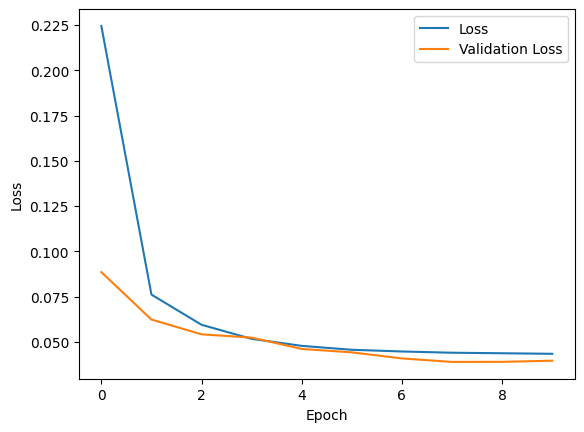

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Postprocessing

In [ ]:
def postprocess_flow(arr):
  arr = (arr*flow_training_std3) + flow_training_mean3
  return arr

def postprocess_snow(arr):
  arr = (arr*snow_training_std3) + snow_training_mean3
  return arr

def postprocess_temp(arr):
  arr = (arr*temp_training_std3) + temp_training_mean3
  return arr


def predictions(model, X, y):
  predictions = model.predict(X)
  flow_preds, snow_preds, temp_preds = postprocess_flow(predictions[:, 0]), postprocess_snow(predictions[:, 1]), postprocess_temp(predictions[:, 2])
  flow_actuals, snow_actuals, temp_actuals = postprocess_flow(y[:, 0]), postprocess_snow(y[:, 1]), postprocess_temp(y[:, 2])
  df = pd.DataFrame(data={'Flow Predictions': flow_preds,
                          'Flow Actuals': flow_actuals,
                          'Snow Predictions': snow_preds,
                          'Snow Actuals':snow_actuals,
                          'Temp Predictions': temp_preds,
                          'Temp Actuals':temp_actuals
                          })
  return df

In [ ]:
post_processed_df = predictions(model5, X3_test, y3_test)
start_date = '2019-12-02'
post_processed_df.index = pd.to_datetime(post_processed_df.index, unit='D', origin=pd.Timestamp(start_date))

52/52 [==============================] - 1s 4ms/step


In [ ]:
post_processed_df

,Flow Predictions,Flow Actuals,Snow Predictions,Snow Actuals,Temp Predictions,Temp Actuals
2019-12-02,312.339203,302.000031,3.316725,3.536364,27.739429,28.432728
2019-12-03,324.878693,302.000031,3.392706,3.518182,23.876480,28.089092
2019-12-04,330.110840,302.000031,3.403940,3.545455,25.217270,26.338182
2019-12-05,334.831757,302.000031,3.485153,3.600000,22.975121,25.143637
2019-12-06,337.016235,302.000031,3.556400,3.590909,22.719830,29.234547
...,...,...,...,...,...,...
2024-06-10,5170.319336,5290.000000,1.201452,0.954545,48.495724,51.134003
2024-06-11,5001.100586,5190.000000,0.945599,0.940000,50.816582,55.700001
2024-06-12,4999.406250,5030.000000,0.823315,0.911111,53.227058,57.830002
2024-06-13,4932.872070,4780.000000,0.821179,1.700000,54.339912,47.152729


### Results

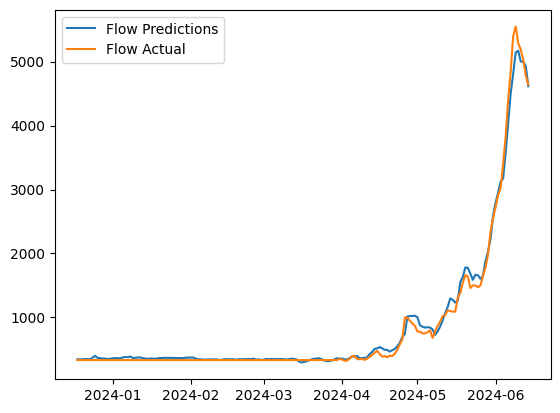

In [ ]:
start, end = len(post_processed_df)-180, len(post_processed_df)
plt.plot(post_processed_df['Flow Predictions'][start:end], label='Flow Predictions')
plt.plot(post_processed_df['Flow Actuals'][start:end], label='Flow Actual')
plt.legend()

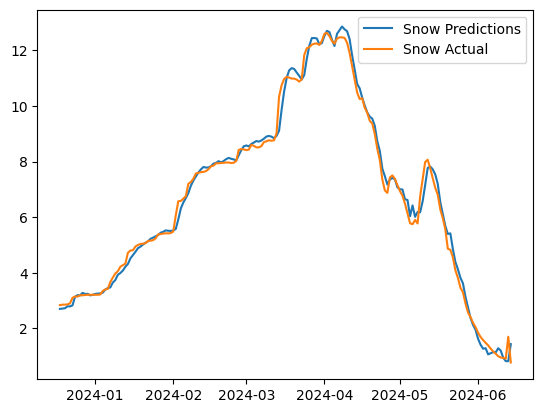

In [ ]:
plt.plot(post_processed_df['Snow Predictions'][start:end], label='Snow Predictions')
plt.plot(post_processed_df['Snow Actuals'][start:end], label='Snow Actual')
plt.legend()

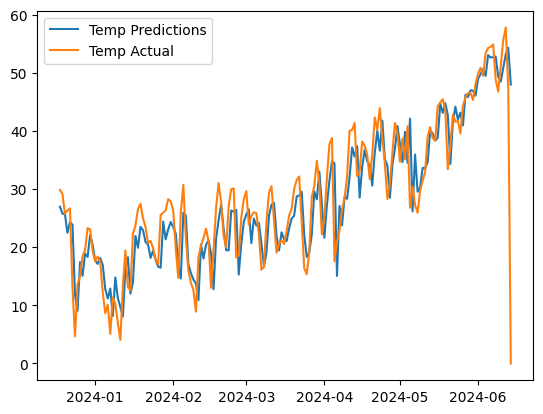

In [ ]:
plt.plot(post_processed_df['Temp Predictions'][start:end], label='Temp Predictions')
plt.plot(post_processed_df['Temp Actuals'][start:end], label='Temp Actual')
plt.legend()

### Forecasting

In [ ]:
n_steps = 7
seconds_ = np.array([])
seconds = combined.index[-1].timestamp()
for i in range(n_steps):
    seconds = seconds + 60*60*24
    seconds_ = np.append(seconds_, seconds)

year = 365.2425 * 24 * 60 * 60
day_sin = np.sin(seconds_ * (2 * np.pi / year))
day_cos = np.cos(seconds_ * (2 * np.pi / year))

In [ ]:
def forecast2(model, data, window_size, n_steps):
  forecasted_flow = np.zeros(n_steps)
  forecasted_snow = np.zeros(n_steps)
  forecasted_temp = np.zeros(n_steps)
  current_data = data.reshape(1, window_size, 5)

  for i in range(n_steps):
    # Predict the next flow and snow values
    predictions = model.predict(current_data)
    next_flow = predictions[0, 0]
    next_snow = predictions[0, 1]
    next_temp = predictions[0, 2]

    # Append the predictions to the forecasted lists
    forecasted_flow[i] = next_flow
    forecasted_snow[i] = next_snow
    forecasted_temp[i] = next_temp


    # Prepare the next input data
    next_input = np.array([[next_flow, next_snow, next_temp, day_sin[i], day_cos[0]]])

    # Append the new input to the current data and slide the window
    current_data = np.concatenate([current_data[:, 1:, :], next_input.reshape(1, 1, 5)], axis=1)

  return forecasted_flow, forecasted_snow, forecasted_temp

In [ ]:
last_window = X3_test[-1]

# Forecast the next n_steps values
forecasted_values = forecast2(model5, last_window, WINDOW_SIZE, n_steps)

print("Forecasted flow:", postprocess_flow(forecasted_values[0]))
print("Forecasted snow:", postprocess_snow(forecasted_values[1]))
print("Forecasted snow:", postprocess_temp(forecasted_values[2]))

forecast_start = post_processed_df.index[-1] + timedelta(days=1)
forecast_end = forecast_start + timedelta(days=n_steps-1)
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='D')

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame({
    'Flow Predicted': postprocess_flow(forecasted_values[0]),
    'Snow Predicted': postprocess_snow(forecasted_values[1]),
    'Temp Predicted': postprocess_temp(forecasted_values[2])
}, index=forecast_index)

1/1 [==============================] - 0s 21ms/step
Forecasted flow: [4614.72712681 4390.17060436 4221.92630947 4107.76441167 4031.99363502
 3980.53592264 3943.79628013]
Forecasted snow: [1.43443833 1.30237393 1.10550641 0.95129769 0.82622889 0.70956775
 0.59281531]
Forecasted snow: [48.01660652 49.88255014 50.83981348 51.50576023 52.08540863 52.62152839
 53.124702  ]


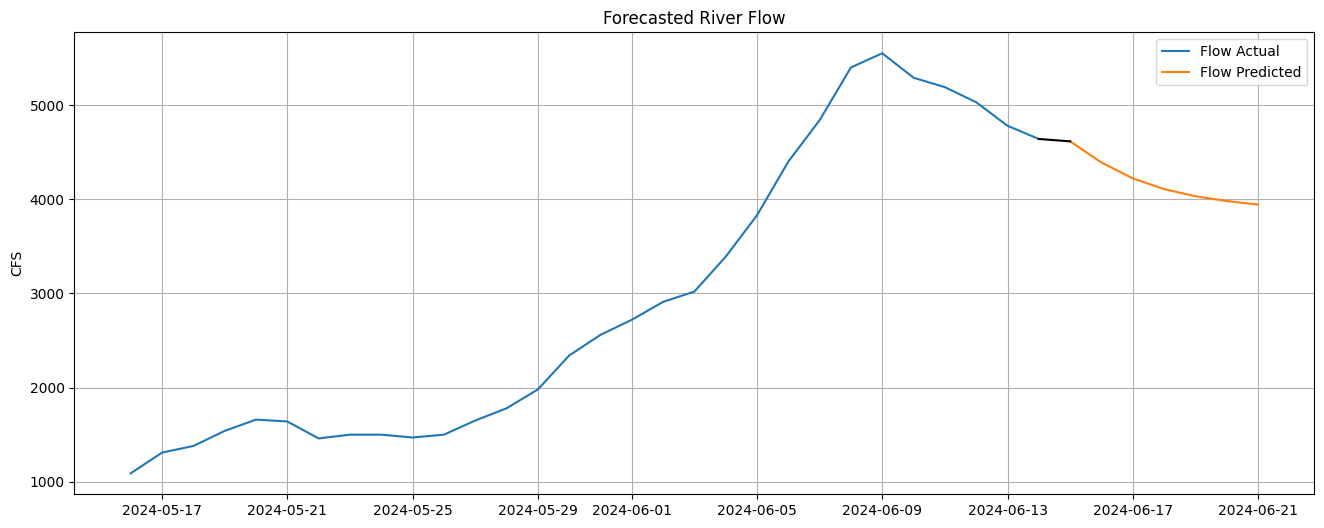

In [ ]:
start, end = post_processed_df.index[-30], post_processed_df.index[-1]
plt.figure(figsize=(16, 6))
plt.plot(post_processed_df['Flow Actuals'][start:end], label='Flow Actual')
plt.plot(forecast_df['Flow Predicted'], label='Flow Predicted')
plt.plot([end, forecast_start], [post_processed_df['Flow Actuals'].iloc[-1], forecast_df['Flow Predicted'].iloc[0]], 'k-')
plt.ylabel('CFS')
plt.title('Forecasted River Flow')
plt.legend()
plt.grid()
plt.show()

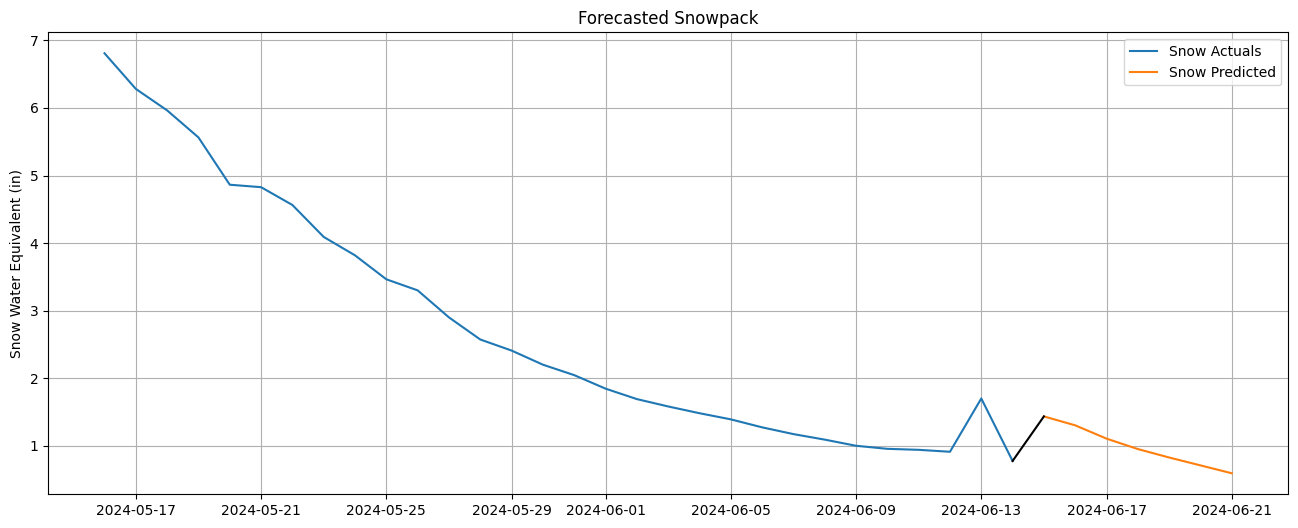

In [ ]:
start, end = post_processed_df.index[-30], post_processed_df.index[-1]
plt.figure(figsize=(16, 6))
plt.plot(post_processed_df['Snow Actuals'][start:end], label='Snow Actuals')
plt.plot(forecast_df['Snow Predicted'], label='Snow Predicted')
plt.plot([end, forecast_start], [post_processed_df['Snow Actuals'].iloc[-1], forecast_df['Snow Predicted'].iloc[0]], 'k-')
plt.ylabel('Snow Water Equivalent (in)')
plt.title('Forecasted Snowpack')
plt.legend()
plt.grid()
plt.show()

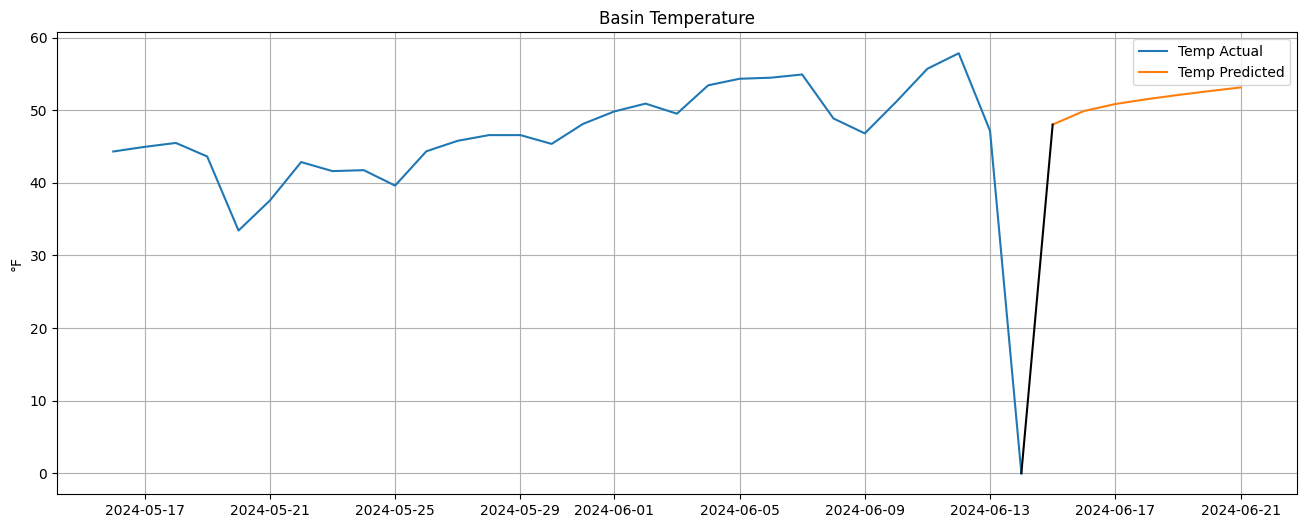

In [ ]:
start, end = post_processed_df.index[-30], post_processed_df.index[-1]
plt.figure(figsize=(16, 6))
plt.plot(post_processed_df['Temp Actuals'][start:end], label='Temp Actual')
plt.plot(forecast_df['Temp Predicted'], label='Temp Predicted')
plt.plot([end, forecast_start], [post_processed_df['Temp Actuals'].iloc[-1], forecast_df['Temp Predicted'].iloc[0]], 'k-')
plt.ylabel('°F')
plt.title('Basin Temperature')
plt.legend()
plt.grid()
plt.show()